In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import torch
from kornia_moons.feature import *
import pycolmap
import os
import h5py
import kornia as K
import kornia.feature as KF
from fastprogress import progress_bar
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
import numpy as np

def load_torch_image(fname, device=torch.device('cpu')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('cpu')



## Download example data

In [93]:

!wget http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip

--2023-03-13 14:17:32--  http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34534975 (33M) [application/zip]
Saving to: ‘wooden_lady_subset.zip.1’

wooden_lady_subset. 100%[===================>]  32,93M  6,53MB/s    in 5,1s    

2023-03-13 14:17:37 (6,50 MB/s) - ‘wooden_lady_subset.zip.1’ saved [34534975/34534975]



In [4]:
%%capture
!unzip -o wooden_lady_subset.zip

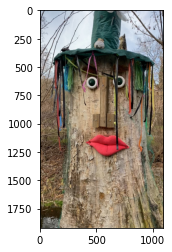

In [2]:
dirname = 'wooden_lady_subset'
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.jpg' in x]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

## LoFTR Matching

In [28]:


def get_unique_idxs(A, dim=1):
    # https://stackoverflow.com/questions/72001505/how-to-get-unique-elements-and-their-firstly-appeared-indices-of-a-pytorch-tenso
    unique, idx, counts = torch.unique(A, dim=dim, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0],device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies

def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout_loftr',
                   device=torch.device('cpu'),
                   min_matches=15, resize_to_ = (640, 480)):
    matcher = KF.LoFTR(pretrained='outdoor').to(device).eval()
    # First we do pairwise matching, and then extract "keypoints" from loftr matches

    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='w') as f_match:
        for pair_idx in progress_bar(index_pairs):
            idx1, idx2 = pair_idx
            fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
            key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
            # Load img1
            timg1 = K.color.rgb_to_grayscale(load_torch_image(fname1, device=device))
            H1, W1 = timg1.shape[2:]
            if H1 < W1:
                resize_to = resize_to_[1], resize_to_[0]
            else:
                resize_to = resize_to_
            timg_resized1 = K.geometry.resize(timg1, resize_to, antialias=True)
            h1, w1 = timg_resized1.shape[2:]

            # Load img2
            timg2 = K.color.rgb_to_grayscale(load_torch_image(fname2, device=device))
            H2, W2 = timg2.shape[2:]
            if H2 < W2:
                resize_to2 = resize_to[1], resize_to[0]
            else:
                resize_to2 = resize_to_
            timg_resized2 = K.geometry.resize(timg2, resize_to2, antialias=True)
            h2, w2 = timg_resized2.shape[2:]
            with torch.inference_mode():
                input_dict = {"image0": timg_resized1,"image1": timg_resized2}
                correspondences = matcher(input_dict)
            mkpts0 = correspondences['keypoints0'].cpu().numpy()
            mkpts1 = correspondences['keypoints1'].cpu().numpy()

            mkpts0[:,0] *= float(W1) / float(w1)
            mkpts0[:,1] *= float(H1) / float(h1)

            mkpts1[:,0] *= float(W2) / float(w2)
            mkpts1[:,1] *= float(H2) / float(h2)

            n_matches = len(mkpts1)
            group  = f_match.require_group(key1)
            if n_matches >= min_matches:
                 group.create_dataset(key2, data=np.concatenate([mkpts0, mkpts1], axis=1))
    # Let's find unique loftr pixels and group them together
    kpts = defaultdict(list)
    match_indexes = defaultdict(dict)
    total_kpts=defaultdict(int)
    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='r') as f_match:
        for k1 in f_match.keys():
            group  = f_match[k1]
            for k2 in group.keys():
                matches = group[k2][...]
                total_kpts[k1]
                kpts[k1].append(matches[:, :2])
                kpts[k2].append(matches[:, 2:])
                current_match = torch.arange(len(matches)).reshape(-1, 1).repeat(1, 2)
                current_match[:, 0]+=total_kpts[k1]
                current_match[:, 1]+=total_kpts[k2]
                total_kpts[k1]+=len(matches)
                total_kpts[k2]+=len(matches)
                match_indexes[k1][k2]=current_match
    for k in kpts.keys():
        kpts[k] = np.round(np.concatenate(kpts[k], axis=0))
    unique_kpts = {}
    unique_match_idxs = {}
    out_match = defaultdict(dict)
    for k in kpts.keys():
        uniq_kps, uniq_reverse_idxs = torch.unique(torch.from_numpy(kpts[k]),dim=0, return_inverse=True)
        unique_match_idxs[k] = uniq_reverse_idxs
        unique_kpts[k] = uniq_kps.numpy()
    for k1, group in match_indexes.items():
        for k2, m in group.items():
            m2 = deepcopy(m)
            m2[:,0] = unique_match_idxs[k1][m2[:,0]]
            m2[:,1] = unique_match_idxs[k2][m2[:,1]]
            out_match[k1][k2] = m2.numpy()
    with h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp:
        for k, kpts1 in unique_kpts.items():
            f_kp[k] = kpts1
    
    with h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        for k1, gr in out_match.items():
            group  = f_match.require_group(k1)
            for k2, match in gr.items():
                group[k2] = match
    return

                    

In [4]:
# matching all to all
index_pairs = []
for i in range(len(img_fnames)):
    for j in range(i+1, len(img_fnames)):
        index_pairs.append((i,j))


In [29]:
match_features(img_fnames, index_pairs, feature_dir = '.featureout_loftr', device=torch.device('cpu'))

## Import into colmap and run reconstruction

In [30]:
from h5_to_db import add_keypoints, add_matches, COLMAPDatabase

def import_into_colmap(img_dir,
                       feature_dir ='.featureout',
                       database_path = 'colmap.db',
                       img_ext='.jpg'):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, img_dir, img_ext, 'simple-radial', single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )

    db.commit()
    return

database_path = 'colmap_loftr.db'
!rm {database_path}
import_into_colmap(dirname,feature_dir='.featureout_loftr', database_path=database_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 648.23it/s]
253it [00:00, 4324.34it/s]                                                                                                                          


In [33]:
output_path = 'colmap_rec_loftr'


In [31]:

def run_reconstruction(image_dir, output_path = 'colmap_rec', database_path = 'colmap.db'):
    pycolmap.match_exhaustive(database_path)
    maps = pycolmap.incremental_mapping(database_path, dirname, output_path)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
    maps[0].write(output_path)
    return maps

In [34]:
maps = run_reconstruction(dirname, output_path, database_path)


Exhaustive feature matching

Matching block [1/1, 1/1] in 3.934s
Elapsed time: 0.066 [minutes]

Loading database

Loading cameras... 23 in 0.000s
Loading matches... 253 in 0.001s
Loading images... 23 in 0.004s (connected 23)
Building correspondence graph... in 0.012s (ignored 0)

Elapsed time: 0.000 [minutes]


Finding good initial image pair


Initializing with image pair #12 and #10


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.965644e+03    0.00e+00    7.42e+04   0.00e+00   0.00e+00  1.00e+04        0    9.47e-04    4.84e-03
   1  1.100434e+03    8.65e+02    1.60e+05   5.50e+01   9.59e-01  3.00e+04        1    2.74e-03    7.77e-03
   2  9.830777e+02    1.17e+02    8.36e+04   5.61e+01   9.61e-01  9.00e+04        1    1.92e-03    9.70e-03
   3  9.743087e+02    8.77e+00    2.19e+04   2.94e+01   8.06e-01  1.17e+05        1    1.95e-03    1.17e-02
   4  9.724551e+02    1.85e+00    2.00e+04 


Pose refinement report
----------------------
    Residuals : 2406
   Parameters : 8
   Iterations : 12
         Time : 0.00616384 [s]
 Initial cost : 0.759075 [px]
   Final cost : 0.601688 [px]
  Termination : Convergence

  => Continued observations: 1203
  => Added observations: 417

Bundle adjustment report
------------------------
    Residuals : 10420
   Parameters : 5993
   Iterations : 21
         Time : 0.0706491 [s]
 Initial cost : 0.530987 [px]
   Final cost : 0.445929 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 4
  => Filtered observations: 94
  => Changed observations: 0.018810

Bundle adjustment report
------------------------
    Residuals : 10240
   Parameters : 5957
   Iterations : 7
         Time : 0.0233748 [s]
 Initial cost : 0.468533 [px]
   Final cost : 0.452213 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 18
  => Filtered observations: 1
  => Changed observations: 0.0037


Pose refinement report
----------------------
    Residuals : 3694
   Parameters : 8
   Iterations : 18
         Time : 0.014297 [s]
 Initial cost : 0.647206 [px]
   Final cost : 0.556019 [px]
  Termination : Convergence

  => Continued observations: 1844
  => Added observations: 3893

Bundle adjustment report
------------------------
    Residuals : 38728
   Parameters : 18662
   Iterations : 26
         Time : 0.427447 [s]
 Initial cost : 0.519167 [px]
   Final cost : 0.486124 [px]
  Termination : No convergence

  => Merged observations: 95
  => Completed observations: 130
  => Filtered observations: 298
  => Changed observations: 0.027009

Bundle adjustment report
------------------------
    Residuals : 38392
   Parameters : 18695
   Iterations : 6
         Time : 0.10281 [s]
 Initial cost : 0.546811 [px]
   Final cost : 0.529902 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 60
  => Filtered observations: 1
  => Changed observations: 0

   5  1.912412e+04    1.71e-04    1.29e+00   1.33e-01   1.02e+00  2.43e+06        1    2.11e-02    1.31e-01
   6  1.912412e+04    1.11e-06    8.38e-02   8.76e-03   1.08e+00  7.29e+06        1    2.09e-02    1.52e-01


Bundle adjustment report
------------------------
    Residuals : 58108
   Parameters : 24234
   Iterations : 7
         Time : 0.152057 [s]
 Initial cost : 0.575286 [px]
   Final cost : 0.573684 [px]
  Termination : Convergence

  => Completed observations: 1
  => Merged observations: 7
  => Filtered observations: 4
  => Changed observations: 0.000413
  => Filtered images: 0

Registering image #1 (9)

  => Image sees 1652 / 14259 points

Pose refinement report
----------------------
    Residuals : 3240
   Parameters : 8
   Iterations : 11
         Time : 0.00758195 [s]
 Initial cost : 0.656459 [px]
   Final cost : 0.591455 [px]
  Termination : Convergence

  => Continued observations: 1618
  => Added observations: 4384

Bundle adjustment report
------------------------


   2  3.870723e+04    1.03e+01    1.95e+02   6.06e+00   1.00e+00  9.00e+04        1    3.38e-02    1.24e-01
   3  3.870590e+04    1.33e+00    3.89e+02   8.81e+00   9.83e-01  2.70e+05        1    3.26e-02    1.57e-01
   4  3.870542e+04    4.79e-01    2.30e+02   6.73e+00   9.84e-01  8.10e+05        1    3.08e-02    1.88e-01
   5  3.870537e+04    5.00e-02    2.62e+01   2.20e+00   1.01e+00  2.43e+06        1    3.21e-02    2.20e-01
   6  3.870537e+04    7.31e-04    2.00e+00   2.89e-01   1.02e+00  7.29e+06        1    2.99e-02    2.50e-01
   7  3.870537e+04    2.25e-06    8.93e-02   1.75e-02   1.03e+00  2.19e+07        1    3.18e-02    2.82e-01


Bundle adjustment report
------------------------
    Residuals : 96174
   Parameters : 36750
   Iterations : 8
         Time : 0.282216 [s]
 Initial cost : 0.698069 [px]
   Final cost : 0.634391 [px]
  Termination : Convergence

  => Completed observations: 4
  => Merged observations: 0
  => Filtered observations: 22
  => Changed observations: 0.0

  => Filtered observations: 8
  => Changed observations: 0.000227
  => Filtered images: 0

Registering image #21 (14)

  => Image sees 1944 / 14501 points

Pose refinement report
----------------------
    Residuals : 3672
   Parameters : 8
   Iterations : 13
         Time : 0.0104468 [s]
 Initial cost : 0.703228 [px]
   Final cost : 0.616946 [px]
  Termination : Convergence

  => Continued observations: 1832
  => Added observations: 11780

Bundle adjustment report
------------------------
    Residuals : 112252
   Parameters : 23435
   Iterations : 26
         Time : 0.76773 [s]
 Initial cost : 0.570283 [px]
   Final cost : 0.543646 [px]
  Termination : No convergence

  => Merged observations: 1373
  => Completed observations: 73
  => Filtered observations: 671
  => Changed observations: 0.037719

Bundle adjustment report
------------------------
    Residuals : 110992
   Parameters : 22910
   Iterations : 4
         Time : 0.114362 [s]
 Initial cost : 0.634314 [px]
   Final cost : 0

   3  9.896628e+04    2.38e+00    3.36e+02   2.30e+01   9.94e-01  2.70e+05        1    9.10e-02    4.28e-01
   4  9.896531e+04    9.75e-01    3.64e+02   2.33e+01   9.84e-01  8.10e+05        1    8.67e-02    5.15e-01
   5  9.896513e+04    1.77e-01    8.27e+01   1.16e+01   1.01e+00  2.43e+06        1    8.18e-02    5.97e-01
   6  9.896513e+04    6.76e-03    2.76e+00   2.40e+00   1.02e+00  7.29e+06        1    7.97e-02    6.77e-01
   7  9.896513e+04    4.66e-05    7.59e-01   2.20e-01   1.04e+00  2.19e+07        1    8.68e-02    7.64e-01


Bundle adjustment report
------------------------
    Residuals : 232366
   Parameters : 75739
   Iterations : 8
         Time : 0.765627 [s]
 Initial cost : 0.729263 [px]
   Final cost : 0.652612 [px]
  Termination : Convergence

  => Completed observations: 20
  => Merged observations: 12
  => Filtered observations: 63
  => Changed observations: 0.000818

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_rad


Bundle adjustment report
------------------------
    Residuals : 155436
   Parameters : 17225
   Iterations : 26
         Time : 0.859335 [s]
 Initial cost : 0.608563 [px]
   Final cost : 0.592889 [px]
  Termination : No convergence

  => Merged observations: 1498
  => Completed observations: 30
  => Filtered observations: 1253
  => Changed observations: 0.035783

Bundle adjustment report
------------------------
    Residuals : 167666
   Parameters : 18899
   Iterations : 4
         Time : 0.153007 [s]
 Initial cost : 0.668316 [px]
   Final cost : 0.660845 [px]
  Termination : Convergence

  => Merged observations: 496
  => Completed observations: 157
  => Filtered observations: 12
  => Changed observations: 0.007932

Retriangulation

  => Completed observations: 6
  => Merged observations: 75
  => Retriangulated observations: 32

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.323783e+05  

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.836648e+05    0.00e+00    5.79e+04   0.00e+00   0.00e+00  1.00e+04        0    4.26e-02    3.32e-01
   1  1.832274e+05    4.37e+02    1.33e+02   5.13e+00   1.00e+00  3.00e+04        1    1.60e-01    4.92e-01
   2  1.832262e+05    1.13e+00    9.94e+01   1.98e+00   1.01e+00  9.00e+04        1    1.47e-01    6.40e-01
   3  1.832262e+05    6.42e-02    1.45e+01   8.68e-01   1.03e+00  2.70e+05        1    1.39e-01    7.78e-01
   4  1.832262e+05    2.48e-03    1.93e+00   5.05e-01   1.03e+00  8.10e+05        1    1.51e-01    9.30e-01
   5  1.832262e+05    8.41e-05    1.13e+00   1.58e-01   1.03e+00  2.43e+06        1    1.54e-01    1.08e+00
   6  1.832262e+05    1.27e-06    1.60e-01   2.08e-02   1.03e+00  7.29e+06        1    1.44e-01    1.23e+00


Bundle adjustment report
------------------------
    Residuals : 409014
   Parameters : 115372
   Iterations : 7
         Time : 1.23

## Visualize with colmap GUI (yes, it is cheating)

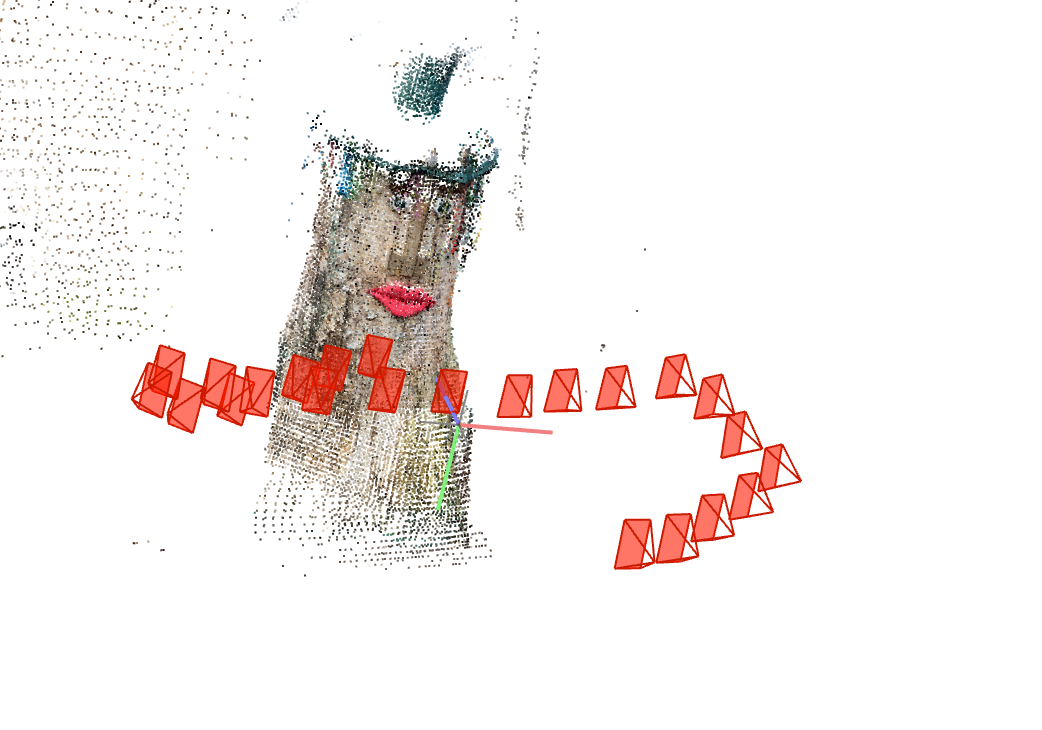